In [1]:
%pylab inline
#%pylab tk

style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import bokeh
import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, Range1d

from ipywidgets import interact

bp.output_notebook()

Loading BokehJS ...

In [3]:
from neuron import h, gui

In [4]:
#CVODE не работает с оригинальными файлами из (Rothman and Manis 2003)
h.cvode_active(0)

0.0

## Используем модель Rothman and Manis 2003

In [5]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [6]:
total_capacitance = 12 # pF

soma_area = total_capacitance * 1e-6 / 1 # pF -> uF, 1 uF/cm^2
soma_diam = 1e4*sqrt(soma_area/pi) # cm->um

print 'Soma area: %02.2e cm^2, diameter: %02.2f um'%(soma_area,soma_diam)
# Isn't it a bit too large a diameter? -> No, it's OK


Soma area: 1.20e-05 cm^2, diameter: 19.54 um


In [7]:
currents = ['klt', 'kht', 'na', 'ka', 'ih', 'hcno', 'leak']

In [8]:
def ns_to_mhocm2(x):
    "Convert from nanosiemens to siemens/cm^2"
    return 1e-9*x/soma_area

In [9]:
ptypeII = {cond:ns_to_mhocm2(val) for cond, val in 
 [('gnabar',1000), ('gkhtbar',150), ('gkltbar', 200),
  ('gabar', 0),  ('ghbar', 20),   ('glk', 2), ]}

ptypeIc = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar', 1000), ('gkhtbar', 150), ('gkltbar', 0),
          ('gabar', 0), ('ghbar', 0.5), ('glk', 2)]}

ptypeIt = {cond:ns_to_mhocm2(val) for cond, val in 
         [('gnabar', 1000), ('gkhtbar', 80), ('gkltbar', 0),
          ('gabar', 65), ('ghbar', 0.5), ('glk', 2)]}

#typeII['glk'] = 0

ptypeIc['Vm0'] = -63.9
ptypeIt['Vm0'] = -64.2
ptypeII['Vm0'] = -63.6 # mV

ptypeIc['Rin'] = 473
ptypeIt['Rin'] = 453
ptypeII['Rin'] = 71    # MOhm
# in S/cm^2
ptypeII

{'Rin': 71,
 'Vm0': -63.6,
 'gabar': 0.0,
 'ghbar': 0.0016666666666666666,
 'gkhtbar': 0.0125,
 'gkltbar': 0.016666666666666666,
 'glk': 0.00016666666666666666,
 'gnabar': 0.08333333333333334}

In [10]:
bushy = h.Section(name='bushy') 
stellatec = h.Section(name='stellatec')
stellatet = h.Section(name='stellatet')

neurons = [(bushy, ptypeII), (stellatec, ptypeIc), (stellatet, ptypeIt)]

def init_neurons():
    h.celsius = 22
    for npx in neurons:
        n,p = npx
        n.nseg = 1
        n.diam = soma_diam
        n.L = soma_diam
        n.Ra = 150
        n.cm = 1
    
        for cur in currents:
            n.insert(cur)
    
        # add and init 'pseudo-mechanism' 
        # to calculate energy rate in each segment
        n.insert('mujpow')
        h.setpointer(n(0.5)._ref_i_ih, 'i_ih', n(0.5).mujpow)
        h.setpointer(n(0.5)._ref_gh_ih, 'gh', n(0.5).mujpow)
    
        n.ek = -70
        n.ena = 50
        n.gbar_hcno = 0
        n.gnabar_na = p['gnabar']
        n.gkhtbar_kht = p['gkhtbar']
        n.gkltbar_klt = p['gkltbar']
        n.gkabar_ka = p['gabar']
        n.ghbar_ih = p['ghbar']
        n.g_leak = p['glk']
    
init_neurons()

In [11]:
h.psection(bushy)

1.0

In [12]:
v_vecb = h.Vector()             # Membrane potential vector
v_vecsc = h.Vector()
v_vecst = h.Vector()
t_vec = h.Vector()             # Time stamp vector

v_vecb.record(bushy(0.5)._ref_v)
v_vecsc.record(stellatec(0.5)._ref_v)
v_vecst.record(stellatet(0.5)._ref_v)

t_vec.record(h._ref_t)


1.0

In [13]:
h.v_init = ptypeII['Vm0']

In [14]:
h.tstop = 2000

In [15]:
h.run()

0.0

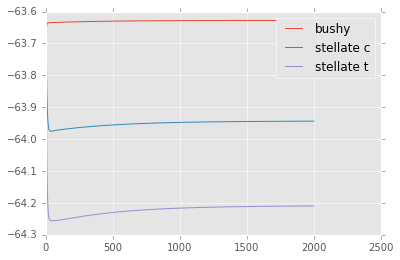

In [16]:
plot(t_vec, v_vecb, label='bushy');
plot(t_vec, v_vecsc, label='stellate c')
plot(t_vec, v_vecst, label='stellate t')
legend ()
#ylim(-70,-50)

In [17]:
for n in neurons:
    print n[0].v

-63.6276537875
-63.9435681279
-64.2094704476


In [18]:
def split_ih(seg, eh=-43):
    "splits ih to Na and K components (crude)"
    v = seg.v
    gh = seg.ih.gh
    gr = float((ena-eh))/(eh-ek)
    
    denom = (v*(gr+1) - gr*seg.ek - seg.ena)
    if (abs(v-eh) < 1):
        gnah = gh/(float(ena - eh)/(ek-eh) + 1.0)
    else: 
        gnah = seg.ih.i/denom
    inah = gnah*(v-seg.ena)
    ikh = gr*gnah*(v-seg.ek)
    return inah, ikh

def check_splitting(v, gratio=5, eh=-43, ek=-70, ena =50):
    ih = ptypeII['ghbar']*(v-eh)
    gr = float((ena-eh))/(eh-ek)
    print gr
    denom = gr*(v-ek) + (v-ena)
    gnah = ih/denom
    inah = gnah*(v-ena)
    ikh = gr*gnah*(v-ek)
    return  inah, ikh, denom

In [19]:
bushy(0.5).gh_ih

0.00024343463240200237

3.44444444444


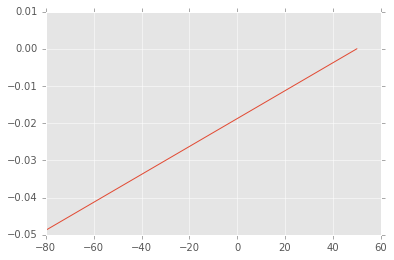

In [20]:
vtest = linspace(-80, 50, 1000)

gratio = 5
ek = -70
ena = 50

plot(vtest, check_splitting(vtest, eh=-43)[0])
#plot(vtest, check_splitting(vtest, eh=-43)[1])
#k = argmin( abs(check_splitting(vtest, eh=-43)))
#vtest[k]

In [21]:
check_splitting(-43.002)

3.44444444444


(-0.034875749999981415, 0.03487241666664808, -0.00888888888890449)

In [22]:
def get_Rin(sec):
    seg = sec(0.5)
    gnar = seg.ina/(seg.v-seg.ena)  # Siemens/cm^2
    gkr = seg.ik/(seg.v-seg.ek)
    ghr = seg.i_ih/(seg.v- -43)
    glkr = seg.leak.i/(seg.v -seg.erev_leak)
    Ginx = (gnar + gkr + ghr + glkr)* seg.area()*1e-8
    return 1e-6/Ginx 

for n in neurons:
    print '{} Rin: {} | {} MOhm'.format(n[0].name(), get_Rin(n[0]), n[1]['Rin'])

bushy Rin: 71.0284615727 | 71 MOhm
stellatec Rin: 473.112176395 | 473 MOhm
stellatet Rin: 452.143818316 | 453 MOhm


## Оценка затрат в покое по Attwell и по Moujahid&D'Anjou


In [23]:
def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def nJ2atp(nJ):
    "convert from nJoule/s to nmol ATP/s"
    return (nJ/F_ATP)*1e-3

In [24]:
def mouj_Erate2(seg, Iap=0, erev_ih = -43):
    v = seg.v
    acc = Iap*v
    inah, ikh = split_ih(seg) # раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    acc += ina*(v-seg.ena) 
    acc += ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak) # Ну и утечка, хотя вклад от нее минимальный
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

In [25]:
def print_ratp_estimate(cell):
    attw = ratp_atwell(cell.v, get_Rin(cell))
    mouj_dh = mouj_Erate2(cell(0.5))
    mouj_atp = nJ2atp(mouj_dh)
    print "Attwell: %.3e pmol ATP/s"%attw
    print "Moujahid: %.3e pmol ATP/s"%mouj_atp
    print "A:M ratio: %2.3f"%(attw/mouj_atp)
    
def print_erate_estimate(cell):
    attw = ratp_atwell(cell.v, get_Rin(cell))
    seg = cell(0.5)
    mouj_dh = mouj_Erate2(seg)
    mujpow = seg.erate_mujpow*seg.area()*1e-8
    attw_erate = atp2J(attw)
    print "Attwell: %.3e pJ/s"%attw_erate
    print "Moujahid: %.3e pJ/s"%mouj_dh
    print "Mujpow dummy mech: %.3e pJ/s"%mujpow
    print "A:M ratio: %2.3f"%(attw_erate/mouj_dh)

In [26]:
for npx in neurons:
    n = npx[0]
    print '===== ', n.name(), ' ====='
    print_erate_estimate(n)
    #print "Mujpow dummy mechanism: ", n.
    print '------\n'


=====  bushy  =====
Attwell: 2.144e+01 pJ/s
Moujahid: 9.044e+00 pJ/s
Mujpow dummy mech: 9.040e+00 pJ/s
A:M ratio: 2.371
------

=====  stellatec  =====
Attwell: 3.072e+00 pJ/s
Moujahid: 3.086e-01 pJ/s
Mujpow dummy mech: 3.064e-01 pJ/s
A:M ratio: 9.954
------

=====  stellatet  =====
Attwell: 3.084e+00 pJ/s
Moujahid: 3.127e-01 pJ/s
Mujpow dummy mech: 3.114e-01 pJ/s
A:M ratio: 9.863
------



## Добавляем синапсы 

In [27]:
# Source of stimuli
afib = h.NetStim() 

In [28]:
afib.interval = 1000/211. # ms 
afib.start = 100 # ms
afib.number = 25 # number of spikes
afib.noise = 0.0 # no randomness so far

gsyn1 = 2e-3 # 2nS -> microsiemens
gsyn_sup = 30e-3 # 2nS -> microsiemens

In [29]:
Nsyn = 1
synapses = []
connections = []

testseg = bushy(0.5)

for k in range(Nsyn):
    syn = h.Exp2Syn(testseg) 
    syn.tau1 = 0.07 # rise time
    syn.tau2 = 0.34 # decay time
    #print syn.e
    con  = h.NetCon(afib, syn, 0, 0, gsyn1)
    synapses.append(syn)
    connections.append(con)
    

In [30]:
rec_variables = ['v', 'erate', 'ih']
bushy_rec = {var: h.Vector() for var in rec_variables}

bushy_rec['v'].record(bushy(0.5)._ref_v)
bushy_rec['erate'].record(bushy(0.5)._ref_erate_mujpow)

1.0

In [31]:
for con in connections:
    con.weight[0] = gsyn1

h.tstop = 500

h.v_init = -63.63
h.run()

0.0

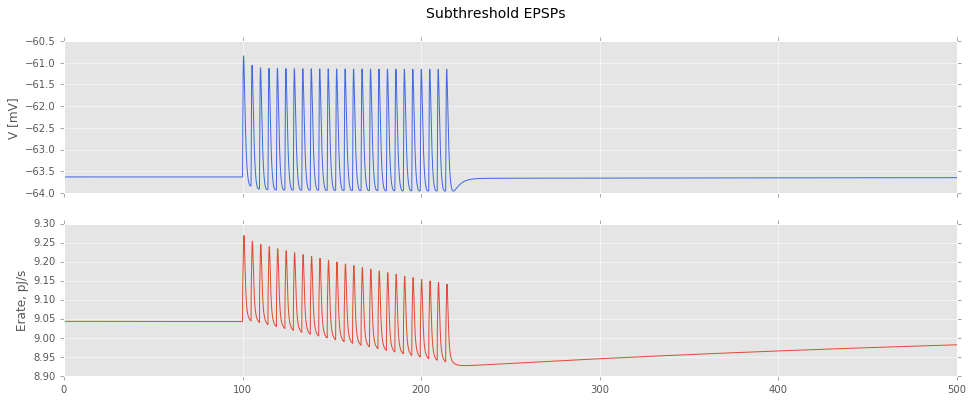

In [32]:
f, axs = subplots(2,1,sharex=True,figsize=(16,6))
axs[0].plot(t_vec, bushy_rec['v'], color='royalblue')
setp(axs[0], ylabel='V [mV]')#, ylim=(-65, -60))
#axs[0].set_ylabel('V, mV')

axs[1].plot(t_vec, array(bushy_rec['erate'])*soma_area)
axs[1].set_ylabel('Erate, pJ/s')
suptitle("Subthreshold EPSPs",size=14)

In [33]:
for con in connections:
    con.weight[0] = gsyn1*50
h.run()

0.0

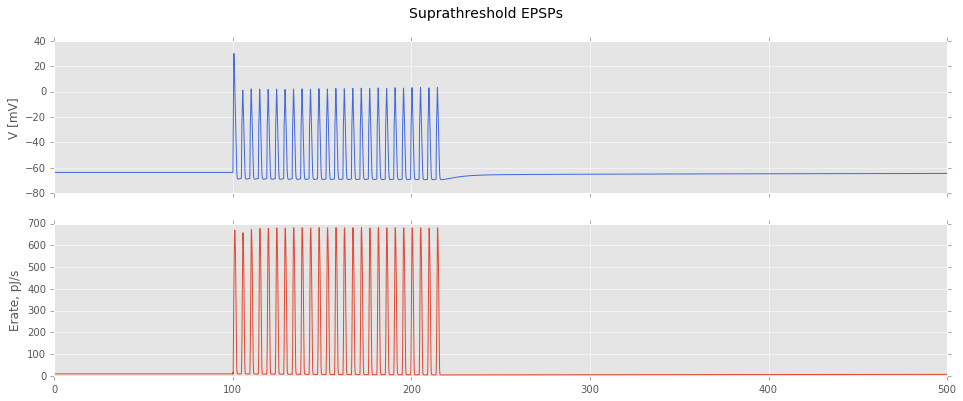

In [34]:
f, axs = subplots(2,1,sharex=True,figsize=(16,6))
axs[0].plot(t_vec, bushy_rec['v'], color='royalblue')
setp(axs[0], ylabel='V [mV]')
#axs[0].set_ylabel('V, mV')

axs[1].plot(t_vec, array(bushy_rec['erate'])*soma_area)
axs[1].set_ylabel('Erate, pJ/s')
#xlim(138,145)
#ylim(-2000,2000)
suptitle("Suprathreshold EPSPs",size=14)

In [35]:
## Too slow...
p1 = bp.Figure(plot_height=400, plot_width=900, 
              x_axis_label='time [ms]', y_axis_label='V [mV]')
p2 = bp.Figure(plot_height=400, plot_width=900, 
              x_axis_label='time [ms]', y_axis_label='dEdt pJoule/s')
p1.line(t_vec, bushy_rec['v'], line_width=1,)
p2.line(t_vec, array(bushy_rec['erate'])*soma_area, line_width=1,)
bp.show(bp.vplot(p1,p2))

## Simulation control from Python


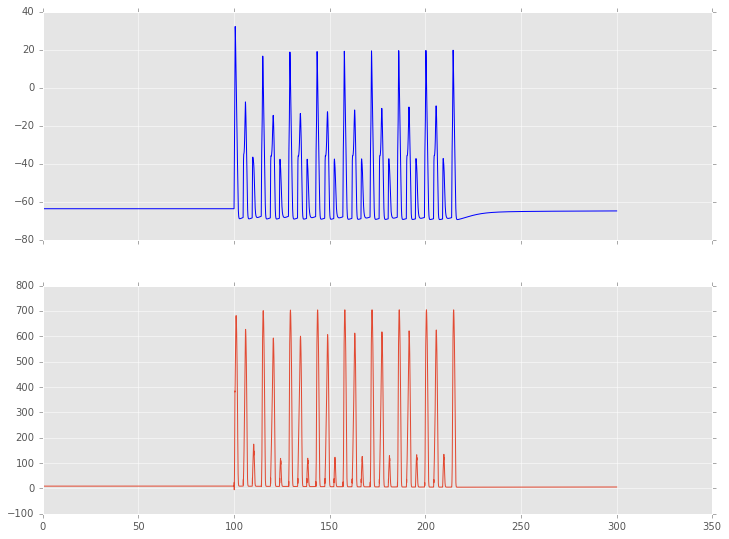

In [50]:
h.dt = 0.01
tstop = 300


for con in connections:
    con.weight[0] = gsyn1*30

def initialize():
    h.finitialize(h.v_init)
    h.fcurrent()

    
def integrate():
    #tstamps =  []
    #erate = []
    #v = []
    out = []
    seg = bushy(0.5)
    while h.t < tstop:
        h.fadvance()
        isyn = np.sum([syn.i for syn in synapses])
        out.append([h.t, mouj_Erate2(seg), seg.v, isyn])
    return array(out).T

def go():
    initialize()
    traj = integrate()
    tx, erate,v,isyn = traj
    f, axs = subplots(2,1,sharex=True, figsize=(12,9))
    axs[0].plot(tx, v,'b-')
    axs[1].plot(tx, erate, '-')
    return traj


data = go()


(99, 102)

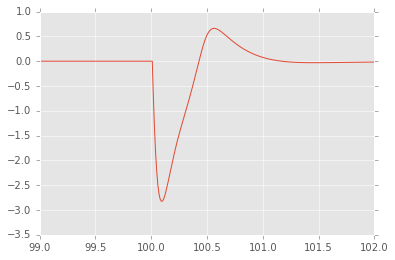

In [55]:
plot(data[0], data[-1])
xlim(99,102)

In [56]:
def synaptic_curr2pJ(isyn,v,ena=50):
    "Let's say 2/3 of the current is mediated by Na+"
    #cur = (2./3) * isyn 
    return 